In [8]:
from pathlib import Path
import shutil
import random
import yaml
import subprocess
import sys
import urllib.request
import zipfile

from ultralytics.models import YOLO
import torch
from IPython.display import Image as IPImage, display
from tqdm import tqdm

In [2]:
TXT_PATH = Path("txt_output_folder")
IMG_PATH = Path("balls")
DATASET_ROOT = Path("yolo_dataset")
COCO_DIR = Path("coco_persons")
COMBINED_DATASET = Path("yolo_dataset_combined")

TRAIN_RATIO = 0.8
NUM_PERSON_IMAGES = 200
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
random.seed(42)

print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")

Device: cuda:0
GPU: NVIDIA GeForce RTX 3080 Laptop GPU
CUDA: 12.8


## Step 1: Prepare Ball Dataset

In [ ]:
for split in ['train', 'val']:
    (DATASET_ROOT / split / "images").mkdir(parents=True, exist_ok=True)
    (DATASET_ROOT / split / "labels").mkdir(parents=True, exist_ok=True)

txt_files = list(TXT_PATH.glob("*.txt"))
data_pairs = []

for txt_file in txt_files:
    stem = txt_file.stem
    img_file = None
    for ext in ['.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG']:
        candidate = IMG_PATH / f"{stem}{ext}"
        if candidate.exists():
            img_file = candidate
            break
    if img_file:
        data_pairs.append((img_file, txt_file))

random.shuffle(data_pairs)
split_idx = int(len(data_pairs) * TRAIN_RATIO)
train_pairs = data_pairs[:split_idx]
val_pairs = data_pairs[split_idx:]

for img_file, txt_file in train_pairs:
    shutil.copy(img_file, DATASET_ROOT / "train" / "images" / img_file.name)
    shutil.copy(txt_file, DATASET_ROOT / "train" / "labels" / txt_file.name)

for img_file, txt_file in val_pairs:
    shutil.copy(img_file, DATASET_ROOT / "val" / "images" / img_file.name)
    shutil.copy(txt_file, DATASET_ROOT / "val" / "labels" / txt_file.name)

print(f"Ball dataset: train={len(train_pairs)}, val={len(val_pairs)}")

## Step 2: Download COCO Person Data

In [ ]:
from pycocotools.coco import COCO

In [ ]:
COCO_DIR.mkdir(exist_ok=True)
annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
annotations_zip = COCO_DIR / "annotations_trainval2017.zip"
annotations_dir = COCO_DIR / "annotations"

if not annotations_dir.exists():
    print("Downloading COCO annotations...")
    urllib.request.urlretrieve(annotations_url, annotations_zip)
    
    with zipfile.ZipFile(annotations_zip, 'r') as zip_ref:
        zip_ref.extractall(COCO_DIR)
    print("Extraction complete")

annFile = annotations_dir / 'instances_train2017.json'
coco = COCO(str(annFile))
person_cat_id = 1

print(f"COCO annotations loaded (person category: {person_cat_id})")

In [ ]:
images_dir = COCO_DIR / "images"
labels_dir = COCO_DIR / "labels"
images_dir.mkdir(exist_ok=True)
labels_dir.mkdir(exist_ok=True)

img_ids = coco.getImgIds(catIds=[person_cat_id])[:NUM_PERSON_IMAGES]
imgs = coco.loadImgs(img_ids)

print(f"Selected {len(imgs)} COCO images with persons")

def coco_segmentation_to_yolo(segmentation: list, img_width: int, img_height: int) -> list[float] | None:
    if isinstance(segmentation, list) and len(segmentation) > 0:
        polygon = segmentation[0]
        points = []
        for i in range(0, len(polygon), 2):
            x = polygon[i] / img_width
            y = polygon[i+1] / img_height
            points.extend([x, y])
        return points
    return None

downloaded = 0
for img_info in tqdm(imgs, desc="Processing"):
    img_id = img_info['id']
    img_filename = img_info['file_name']
    img_path = images_dir / img_filename
    
    if not img_path.exists():
        try:
            urllib.request.urlretrieve(img_info['coco_url'], img_path)
            downloaded += 1
        except:
            continue
    
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=[person_cat_id], iscrowd=0)
    anns = coco.loadAnns(ann_ids)
    
    label_path = labels_dir / (img_path.stem + '.txt')
    with open(label_path, 'w') as f:
        for ann in anns:
            if 'segmentation' in ann and ann['segmentation']:
                points = coco_segmentation_to_yolo(
                    ann['segmentation'], 
                    img_info['width'], 
                    img_info['height']
                )
                if points:
                    line = "1 " + " ".join([f"{p:.6f}" for p in points])
                    f.write(line + "\n")

print(f"Downloaded {downloaded} new images")

## Step 3: Combine Datasets

In [ ]:
for split in ['train', 'val']:
    (COMBINED_DATASET / split / "images").mkdir(parents=True, exist_ok=True)
    (COMBINED_DATASET / split / "labels").mkdir(parents=True, exist_ok=True)

for split in ['train', 'val']:
    src_imgs = DATASET_ROOT / split / "images"
    src_labels = DATASET_ROOT / split / "labels"
    dst_imgs = COMBINED_DATASET / split / "images"
    dst_labels = COMBINED_DATASET / split / "labels"
    
    for img_file in src_imgs.glob("*.jpg"):
        shutil.copy(img_file, dst_imgs / img_file.name)
        label_file = src_labels / (img_file.stem + '.txt')
        if label_file.exists():
            shutil.copy(label_file, dst_labels / label_file.name)

coco_images = list(images_dir.glob("*.jpg"))
random.shuffle(coco_images)

split_idx = int(len(coco_images) * 0.8)
train_coco = coco_images[:split_idx]
val_coco = coco_images[split_idx:]

for img_file in train_coco:
    shutil.copy(img_file, COMBINED_DATASET / "train" / "images" / img_file.name)
    label_file = labels_dir / (img_file.stem + '.txt')
    if label_file.exists():
        shutil.copy(label_file, COMBINED_DATASET / "train" / "labels" / label_file.name)

for img_file in val_coco:
    shutil.copy(img_file, COMBINED_DATASET / "val" / "images" / img_file.name)
    label_file = labels_dir / (img_file.stem + '.txt')
    if label_file.exists():
        shutil.copy(label_file, COMBINED_DATASET / "val" / "labels" / label_file.name)

yaml_data = {
    'path': str(COMBINED_DATASET.absolute()),
    'train': 'train/images',
    'val': 'val/images',
    'nc': 2,
    'names': {0: 'ball', 1: 'person'}
}

yaml_path = COMBINED_DATASET / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_data, f, default_flow_style=False)

train_total = len(list((COMBINED_DATASET / 'train' / 'images').glob('*.jpg')))
val_total = len(list((COMBINED_DATASET / 'val' / 'images').glob('*.jpg')))
print(f"Combined dataset: train={train_total}, val={val_total}")

## Step 4: Training

In [3]:
project_name = "ball_person_model_head_only"

In [ ]:
model = YOLO('yolo11n-seg.pt')

head_idx = next((i for i, m in enumerate(model.model.model) if 'Detect' in m.__class__.__name__ or 'Segment' in m.__class__.__name__), len(model.model.model) - 1)
print(f"Head starts at layer: {head_idx}")
print(f"Freezing layers: 0-{head_idx-1}")

results = model.train(
    data=str(yaml_path),
    freeze=list(range(head_idx)),
    epochs=10,
    imgsz=640,
    batch=8,
    device=DEVICE,
    project='runs/segment',
    name=project_name,
    exist_ok=True,
    pretrained=True,
    optimizer='Adam',
    lr0=0.001,
    patience=15,
    save=True,
    save_period=5,
    plots=True,
    workers=0,
    val=False,
    hsv_h=0.01,
    hsv_s=0.5,
    hsv_v=0.3,
    degrees=5.0,
    translate=0.1,
    scale=0.3,
    flipud=0.0,
    fliplr=0.5,
    mosaic=0.5
)

print(f"Model saved: runs/segment/ball_person_model/weights/best.pt")

## Step 5: Load Trained Model

Execute this cell to load the trained model (without retraining)

In [4]:
model_path = Path('runs/segment') / project_name / "weights"/ "best.pt"

model = YOLO(str(model_path))


## Step 6: Validation

In [ ]:
metrics = model.val(
    data=str(yaml_path),
    batch=8,
    workers=0,
    device=DEVICE
)

print(f"Box - mAP50: {metrics.box.map50:.4f}, mAP50-95: {metrics.box.map:.4f}")
print(f"Mask - mAP50: {metrics.seg.map50:.4f}, mAP50-95: {metrics.seg.map:.4f}")

for i, name in enumerate(['ball', 'person']):
    if i < len(metrics.seg.ap50):
        print(f"{name}: mAP50={metrics.seg.ap50[i]:.4f}, mAP50-95={metrics.seg.ap[i]:.4f}")

In [ ]:
results_dir = Path('runs/segment/ball_person_model')

if results_dir.exists():
    plots = ['results.png', 'confusion_matrix.png', 'val_batch0_labels.jpg', 'val_batch0_pred.jpg']
    
    for plot in plots:
        plot_path = results_dir / plot
        if plot_path.exists():
            print(f"{plot}:")
            display(IPImage(filename=str(plot_path), width=800))

## Test on Manual Validation Image

In [5]:
from time import perf_counter

In [6]:

def exec_model(img_path: Path, imgsz: int = 255, show=True, show_original_size=False):
    test_manual_img = img_path
    
    start = perf_counter()
    results = model.predict(
        source=str(test_manual_img),
        save=True,
        conf=0.25,
        iou=0.5,
        imgsz=imgsz,
        device=DEVICE,
        show_labels=True,
        show_conf=True,
        project='runs/segment',
        name='manual_validation_pred',
        exist_ok=True,
        verbose=False
    )
    
    for r in results:
        if r.boxes is not None and len(r.boxes) > 0:
            ball_count = sum(1 for cls in r.boxes.cls if int(cls) == 0)
            person_count = sum(1 for cls in r.boxes.cls if int(cls) == 1)
            
            print(f"Detected: {ball_count} ball(s), {person_count} person(s)")
            
            for i, (box, cls) in enumerate(zip(r.boxes.xyxy, r.boxes.cls)):
                class_name = 'ball' if int(cls) == 0 else 'person'
                conf = r.boxes.conf[i]
                print(f"  {class_name}: {conf:.3f}")
            
            pred_path = Path('runs/segment/manual_validation_pred') / test_manual_img.name
            if pred_path.exists() and show:
                width = None if show_original_size else imgsz
                display(IPImage(filename=str(pred_path), width=width))
        else:
            print("No detections")
        
    return perf_counter() - start

In [ ]:
def benchmark_inference(source: Path | list[Path], imgsz: int = 640, runs_per_image: int = 10, warmup_runs: int = 3, use_cpu: bool = False):
    """
    Measure pure inference time without save/display overhead
    
    Args:
        source: Path to folder, single image, or list of image paths
        imgsz: Input image size
        runs_per_image: Number of runs per image
        warmup_runs: Number of warmup runs on first image
        use_cpu: Use CPU instead of GPU
    """
    device = 'cpu' if use_cpu else DEVICE
    
    if isinstance(source, Path):
        if source.is_dir():
            img_paths = list(source.glob("*.jpg")) + list(source.glob("*.png"))
        else:
            img_paths = [source]
    else:
        img_paths = source
    
    device_name = "CPU" if use_cpu else f"GPU ({torch.cuda.get_device_name(0)})"
    print(f"Warming up {device_name} ({warmup_runs} runs)...")
    for _ in range(warmup_runs):
        model.predict(source=str(img_paths[0]), imgsz=imgsz, device=device, save=False, verbose=False)
    
    print(f"Benchmarking {len(img_paths)} images ({runs_per_image} runs each) on {device_name}...")
    all_averages = []
    
    for img_path in tqdm(img_paths):
        times = []
        for _ in range(runs_per_image):
            start = perf_counter()
            model.predict(source=str(img_path), imgsz=imgsz, device=device, save=False, verbose=False)
            times.append(perf_counter() - start)
        
        avg_time = sum(times) / len(times)
        all_averages.append(avg_time)
    
    global_avg = sum(all_averages) / len(all_averages)
    global_min = min(all_averages)
    global_max = max(all_averages)
    
    mean_diff_sq = sum((t - global_avg) ** 2 for t in all_averages) / len(all_averages)
    global_std = mean_diff_sq ** 0.5
    
    print(f"\nGlobal inference time (imgsz={imgsz}, device={device}):")
    print(f"  Average: {global_avg*1000:.2f}ms")
    print(f"  Min: {global_min*1000:.2f}ms")
    print(f"  Max: {global_max*1000:.2f}ms")
    print(f"  Std: {global_std*1000:.2f}ms")
    print(f"  FPS: {1/global_avg:.1f}")
    
    return global_avg, global_min, global_max, global_std

In [ ]:
img_paths = list(Path("df").glob("*.jpg"))

In [ ]:
benchmark_inference(img_paths, imgsz=128, use_cpu=True)

In [ ]:
avg = sum(exec_times) / len(exec_times)
avg

WARNING ⚠️ imgsz=[255] must be multiple of max stride 32, updating to [256]
Results saved to /home/tonino/projects/ball segmentation/runs/segment/manual_validation_pred
Detected: 1 ball(s), 1 person(s)
  person: 0.875
  ball: 0.329


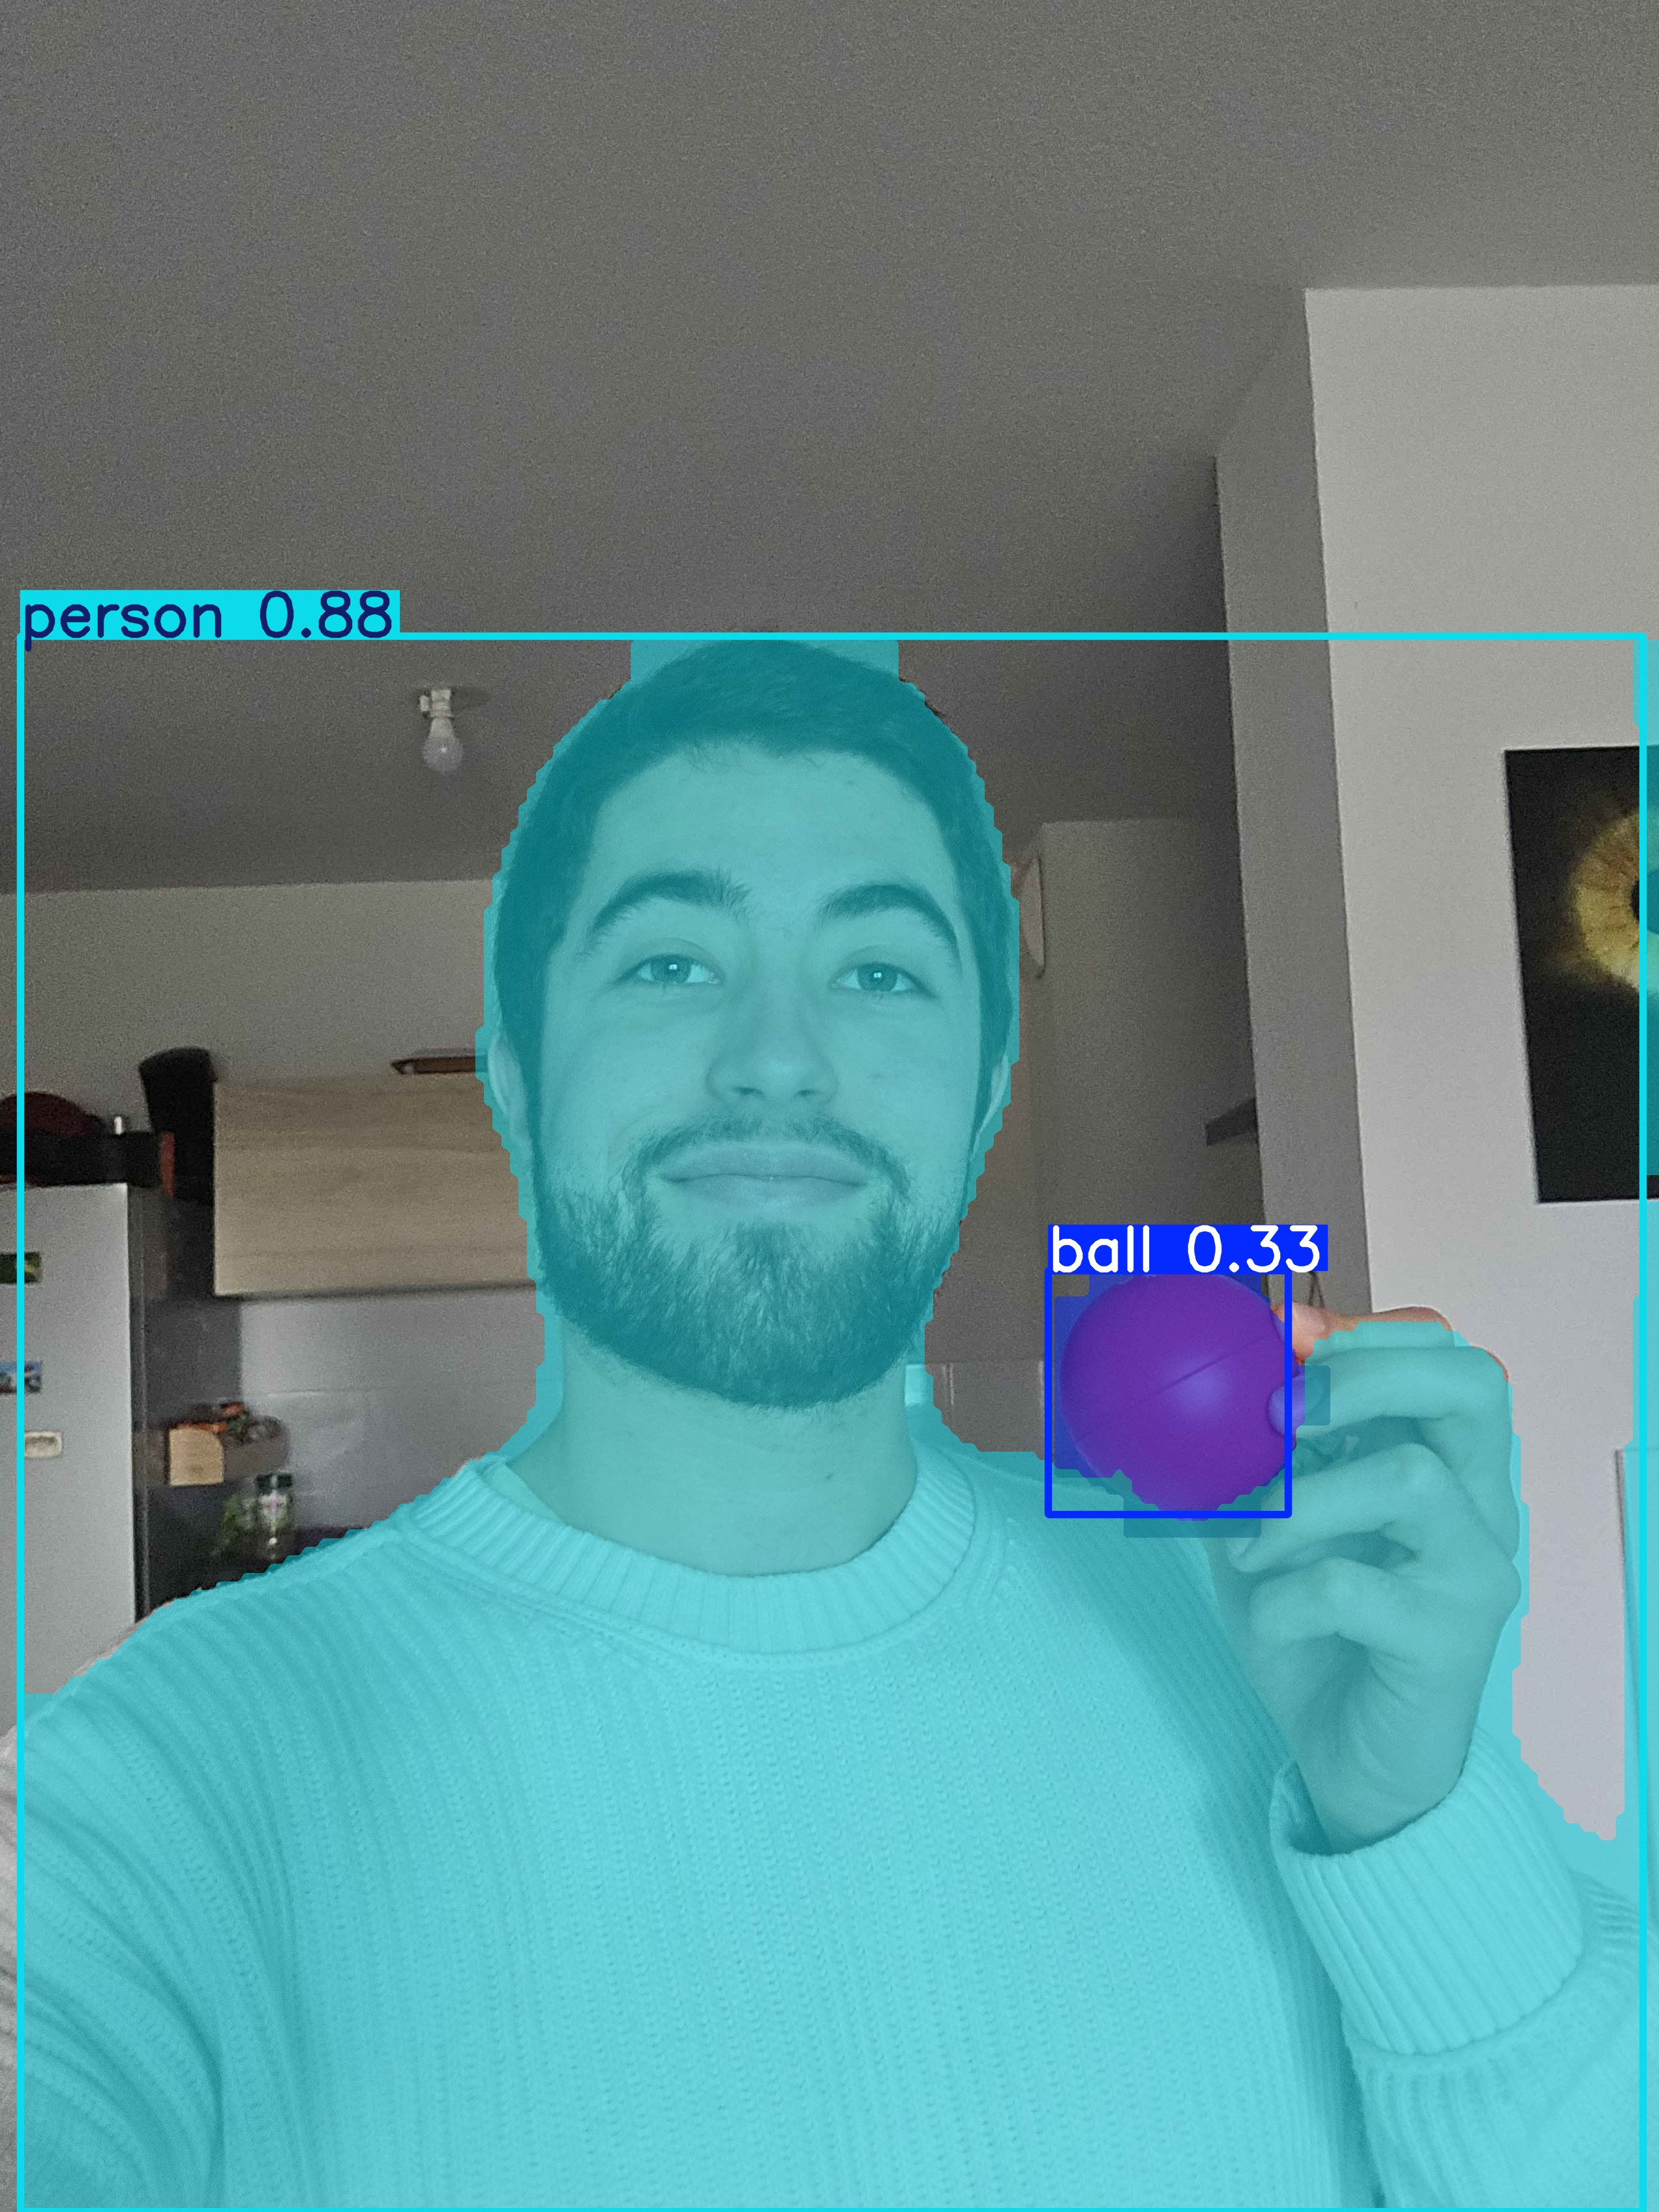

1.5410158839986252

In [7]:
exec_model(Path("20251201_125904.jpg"))